### Loading variables 

In [1]:
import pandas as pd

from df_information import DataFrameInfo
from data_transform import DataTransform
from df_transform import DataFrameTransform
from plotter import Plotter

In [2]:
# load the data into df
df = pd.read_csv('../loan_payments.csv')

In [3]:
# df_info contains methods that generate useful information about the DataFrame
df_info = DataFrameInfo()

# to do conversions on columns of data (e.g. changing its dtype, or date formats)
data_formatter = DataTransform()

# A df_transformer performs EDA transformations on the dataframe e.g. imputation
df_transformer = DataFrameTransform()

# A class to plot helpful visuals
plotter = Plotter()

Loaded DataFrameInfo()...
Loaded DataTransform()...
Loaded DataFrameTransform()...
Loaded Plotter()...


### Summary statistics 

Calling a few basic functions to get an overview of the dataframe. Calls like .head(), .info, .shape and .describe()

In [4]:
df.head()

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term,int_rate,instalment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36 months,7.49,248.82,A,A4,...,0.0,0.0,Jan-2022,248.82,Feb-2022,Jan-2022,0.0,5.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36 months,6.99,407.52,A,A3,...,0.0,0.0,Jan-2022,407.52,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36 months,7.49,497.63,A,A4,...,0.0,0.0,Oct-2021,12850.16,NaN,Oct-2021,0.0,NaN,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36 months,14.31,514.93,C,C4,...,0.0,0.0,Jun-2021,13899.67,NaN,Jun-2021,0.0,NaN,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36 months,6.03,456.54,A,A1,...,0.0,0.0,Jan-2022,456.54,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL


In [5]:
df.shape

(54231, 43)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54231 entries, 0 to 54230
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           54231 non-null  int64  
 1   member_id                    54231 non-null  int64  
 2   loan_amount                  54231 non-null  int64  
 3   funded_amount                51224 non-null  float64
 4   funded_amount_inv            54231 non-null  float64
 5   term                         49459 non-null  object 
 6   int_rate                     49062 non-null  float64
 7   instalment                   54231 non-null  float64
 8   grade                        54231 non-null  object 
 9   sub_grade                    54231 non-null  object 
 10  employment_length            52113 non-null  object 
 11  home_ownership               54231 non-null  object 
 12  annual_inc                   54231 non-null  float64
 13  verification_sta

### Correct the column formats 

#### Object to Date

In [7]:
# Note how the ouptut format is 'Jan-2021'. we want it to be '2022-01-01'.
# The type of the column is also 'object', and not some kind of date.
df['issue_date'].head()

0    Jan-2021
1    Jan-2021
2    Jan-2021
3    Jan-2021
4    Jan-2021
Name: issue_date, dtype: object

In [8]:
# Columns which are currently objects, but need to be converted to dates 
object_to_date_columns = df[['issue_date', 'last_payment_date', 'next_payment_date', 'last_credit_pull_date', 'earliest_credit_line']]

df = data_formatter.convert_obj_columns_to_date(df, column_list=object_to_date_columns, current_format="%b-%Y")

In [9]:
# The output confirms that the format and dtype have been changed.
df['issue_date'].head()

0   2021-01-01
1   2021-01-01
2   2021-01-01
3   2021-01-01
4   2021-01-01
Name: issue_date, dtype: datetime64[ns]

#### Object to category 

In [10]:
# Columns which are object types, but are to be converted to categorical types
obj_into_category_columns = df[['grade', 'sub_grade', 'employment_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'application_type', 'payment_plan', 'term']]
obj_into_category_columns.head()

,grade,sub_grade,employment_length,home_ownership,verification_status,loan_status,purpose,application_type,payment_plan,term
0,A,A4,5 years,MORTGAGE,Not Verified,Current,credit_card,INDIVIDUAL,n,36 months
1,A,A3,9 years,RENT,Not Verified,Current,credit_card,INDIVIDUAL,n,36 months
2,A,A4,8 years,MORTGAGE,Source Verified,Fully Paid,credit_card,INDIVIDUAL,n,36 months
3,C,C4,1 year,RENT,Source Verified,Fully Paid,debt_consolidation,INDIVIDUAL,n,36 months
4,A,A1,10+ years,MORTGAGE,Verified,Current,debt_consolidation,INDIVIDUAL,n,36 months


In [11]:
obj_into_category_columns = data_formatter.convert_object_columns_into_categories(obj_into_category_columns)

#### Numeric to category 

There are some numeric columns, where the vast majority of values are the same, and the rest are spread out with low frequencies. 

Such columns cannot be normally distributed easily, and so I will convert them into categorical columns with ranges to group thier values. 

In [12]:
# This is an example of the kind of value distribution which is better suited to a category with ranges 
df['collection_recovery_fee'].value_counts()

collection_recovery_fee
0.0000      50788
1.4400          7
1.6900          6
1.7300          6
2.0800          6
            ...  
506.8728        1
75.6270         1
2.7103          1
2.1780          1
0.2300          1
Name: count, Length: 2944, dtype: int64

The Series `collections_12_mths_ex_med` only contains 5 values and so it is easy to convert to a category:

In [13]:
df['collections_12_mths_ex_med'].value_counts()

collections_12_mths_ex_med
0.0    53971
1.0      193
2.0       14
3.0        1
4.0        1
Name: count, dtype: int64

In [14]:
# Convert directly into a category 
df['collections_12_mths_ex_med'] = df['collections_12_mths_ex_med'].astype('category')

The following 5 columns, (`delinq_2yrs`, `inq_last_6mths`, `recoveries`, `total_rec_late_fee`, ``collection_recovery_fee``), contain many more values, and so I will create ranges from the spread of each columns' data to create the categories. 

In [15]:
df['delinq_2yrs'] = data_formatter.int64_to_category_with_ranges(df, df['delinq_2yrs'])
df['inq_last_6mths'] = data_formatter.int64_to_category_with_ranges(df, df['inq_last_6mths'])

In [16]:
# These columns are all floats, so I will convert them to integers first since no important information is lost in this process.
df['recoveries'] = round(df['recoveries']).astype('Int64')
df['recoveries'] = data_formatter.int64_to_category_with_ranges(df, df['recoveries'])

df['total_rec_late_fee'] = round(df['total_rec_late_fee']).astype('Int64')
df['total_rec_late_fee'] = data_formatter.int64_to_category_with_ranges(df, df['total_rec_late_fee'])

df['collection_recovery_fee'] = round(df['collection_recovery_fee']).astype('Int64')
df['collection_recovery_fee'] = data_formatter.int64_to_category_with_ranges(df, df['collection_recovery_fee'])

#### Float64 to Int64

In [17]:
# These four columns all represent a number of months, and so can be cast to Int64s 
# The capital I in Int64 denotes that it can handle NA's
float64_columns_into_Int64 = df[['mths_since_last_major_derog', 'mths_since_last_delinq', 'mths_since_last_record']]
float64_columns_into_int64 = data_formatter.convert_float64_columns_into_Int64s(float64_columns_into_Int64)

There are some columns which I am unsure about converting to categories, so I will leave them as they are for now. They are also hard to distribute symetrically, but I am not confident that they actually should be. For future reference, they are:
- last_payment_amount
- open_accounts
- out_prncp_inv
- out_prncp

### Redundant features 

Some columns don't appear to be very useful, so let us see if they are worth removing.

##### grade vs sub_grade

In [18]:
pd.concat([df['grade'], df['sub_grade']], axis=1).head()

,grade,sub_grade
0,A,A4
1,A,A3
2,A,A4
3,C,C4
4,A,A1


Based on the above it seems as though the grade column is redundant, since the grade is always contained in the sub_grade. Let me test this first.

In [19]:
# Check if sub_grade's first letter matches grade 
# Example: if grade is A, sub_grade[0] MUST also be A. This relationship should hold for every grade-sub_grade pair.
grade_matches = df['grade'] == df['sub_grade'].str[0]

# Check if the relationship holds for all pairs 
if grade_matches.all():
  print('True: sub_grade always contains the grade')
else:
  print('False: sub_grade does not always contain the grade')

True: sub_grade always contains the grade


It is true, so I will go ahead and remove grade from the dataframe. 

In [20]:
df = df_transformer.drop_column(df, df['grade'])

##### payment_plan

The value_counts() of payment_plan show that only one value of the ~54,000 values are 'y'. The rest are 'n'. This likely has a negligible impact on my analysis so I will remove this feature.

In [21]:
df['payment_plan'].value_counts()

payment_plan
n    54230
y        1
Name: count, dtype: int64

In [22]:
df = df_transformer.drop_column(df, df['payment_plan'])

##### policy_code

In [23]:
df['policy_code'].nunique()

1

In [24]:
# We can see above that there is only 1 value in the policy_code column, so we may as well delete it. 
df = df_transformer.drop_column(df, df['policy_code'])

### Handle null values

I will first identify the variables with missing values and determine the percentage of missing values in each variable.

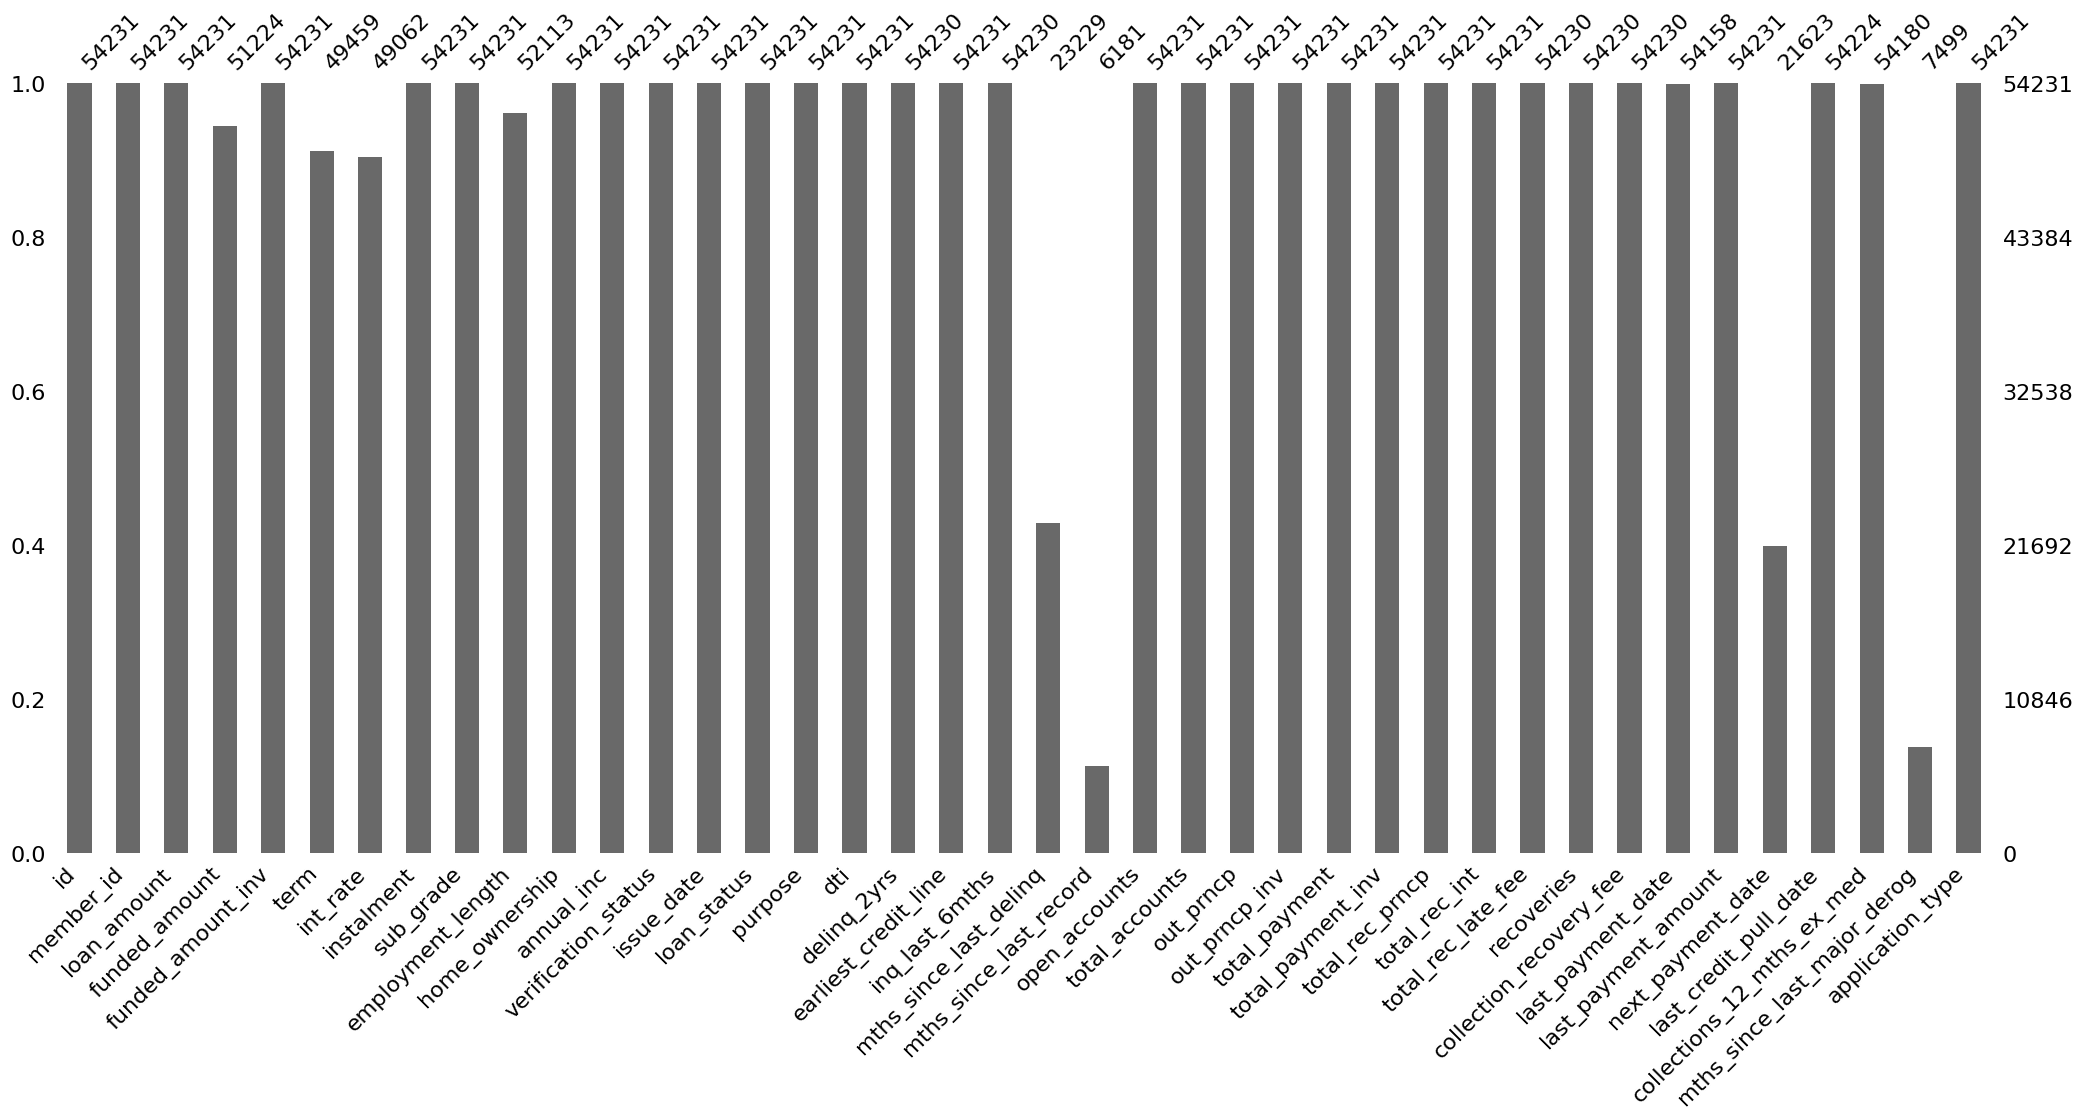

In [25]:
plot = plotter.show_null_bar_chart(df)

In [26]:
message, progress = df_info.print_null_removal_progress(df)
print(message)
progress

There are 16 columns with null values left:



,% of nulls,# of nulls,dtype
mths_since_last_record,88.60,48050,float64
mths_since_last_major_derog,86.17,46732,float64
next_payment_date,60.13,32608,datetime64[ns]
mths_since_last_delinq,57.17,31002,float64
int_rate,9.53,5169,float64
term,8.80,4772,object
funded_amount,5.54,3007,float64
employment_length,3.91,2118,object
last_payment_date,0.13,73,datetime64[ns]
collections_12_mths_ex_med,0.09,51,category


#### Dropping columns

**I now will decide which of the above columns are worth dropping entirely, and proceed to do so.**
Based on the above there are 4 columns with very high proportions of nulls:

`[88.60%, 86.17%, 60.13%, 57.17%]`

The next biggest is 9.53%, which is a huge distance from the top 4.

As a result I am going to *remove all columns with >50% null values*.

In [27]:
# returns a series showing the % of null values for every column in the dataframe
percent_of_nulls = df_info.percentage_of_nulls_in_data_frame(df)

# Extract columns whose majority (> 50%) of values are null, to pass into drop()
more_than_half_null_cols = percent_of_nulls[percent_of_nulls > 50.00]

# Drop the selected columns from the dataframe
df = df_transformer.drop_columns(df, more_than_half_null_cols)

#### Imputing

In [28]:
message, progress = df_info.print_null_removal_progress(df)
print(message)
progress

There are 12 columns with null values left:



,% of nulls,# of nulls,dtype
int_rate,9.53,5169,float64
term,8.80,4772,object
funded_amount,5.54,3007,float64
employment_length,3.91,2118,object
last_payment_date,0.13,73,datetime64[ns]
collections_12_mths_ex_med,0.09,51,category
last_credit_pull_date,0.01,7,datetime64[ns]
delinq_2yrs,0.00,1,category
inq_last_6mths,0.00,1,category
total_rec_late_fee,0.00,1,category


##### Mode imputations

In [29]:
df['term'].value_counts()

term
36 months    35845
60 months    13614
Name: count, dtype: int64

In [30]:
# The term column only has two values, so imputing the missing values using the mode makes the most sense.
df['term'] = df_transformer.impute_nulls_in_column(df['term'], 'mode')

# The employment_length column is categorical and so again mode is the most appropriate replacement. 
df['employment_length'] = df_transformer.impute_nulls_in_column(df['employment_length'], 'mode')

In [31]:
message, progress = df_info.print_null_removal_progress(df)
print(message)
progress

There are 10 columns with null values left:



,% of nulls,# of nulls,dtype
int_rate,9.53,5169,float64
funded_amount,5.54,3007,float64
last_payment_date,0.13,73,datetime64[ns]
collections_12_mths_ex_med,0.09,51,category
last_credit_pull_date,0.01,7,datetime64[ns]
delinq_2yrs,0.00,1,category
inq_last_6mths,0.00,1,category
total_rec_late_fee,0.00,1,category
recoveries,0.00,1,category
collection_recovery_fee,0.00,1,category


##### Median imputations

For this stage I am simply going to use the average to impute `int_rate` and `funded_amount`.

In [32]:
df['int_rate'] = df_transformer.impute_nulls_in_column(df['int_rate'], 'median')

df['funded_amount'] = df_transformer.impute_nulls_in_column(df['funded_amount'], 'median')

In [33]:
message, progress = df_info.print_null_removal_progress(df)
print(message)
progress

There are 8 columns with null values left:



,% of nulls,# of nulls,dtype
last_payment_date,0.13,73,datetime64[ns]
collections_12_mths_ex_med,0.09,51,category
last_credit_pull_date,0.01,7,datetime64[ns]
delinq_2yrs,0.00,1,category
inq_last_6mths,0.00,1,category
total_rec_late_fee,0.00,1,category
recoveries,0.00,1,category
collection_recovery_fee,0.00,1,category


#### Dropping rows 

In [34]:
# These are the last 8 columns, which all have low enough proportions of null values that I am happy to drop the associated rows. 
column_names_with_null_entries = ['last_credit_pull_date', 'collections_12_mths_ex_med', 'last_payment_date', 'delinq_2yrs', 'inq_last_6mths', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee']

df = df_transformer.drop_rows_of_null_column_entries(df, column_names_with_null_entries)

#### Confirm all nulls removed 

In [35]:
message, progress = df_info.print_null_removal_progress(df)
print(message)
progress

There are 0 columns with null values left:



,% of nulls,# of nulls,dtype


<Axes: >

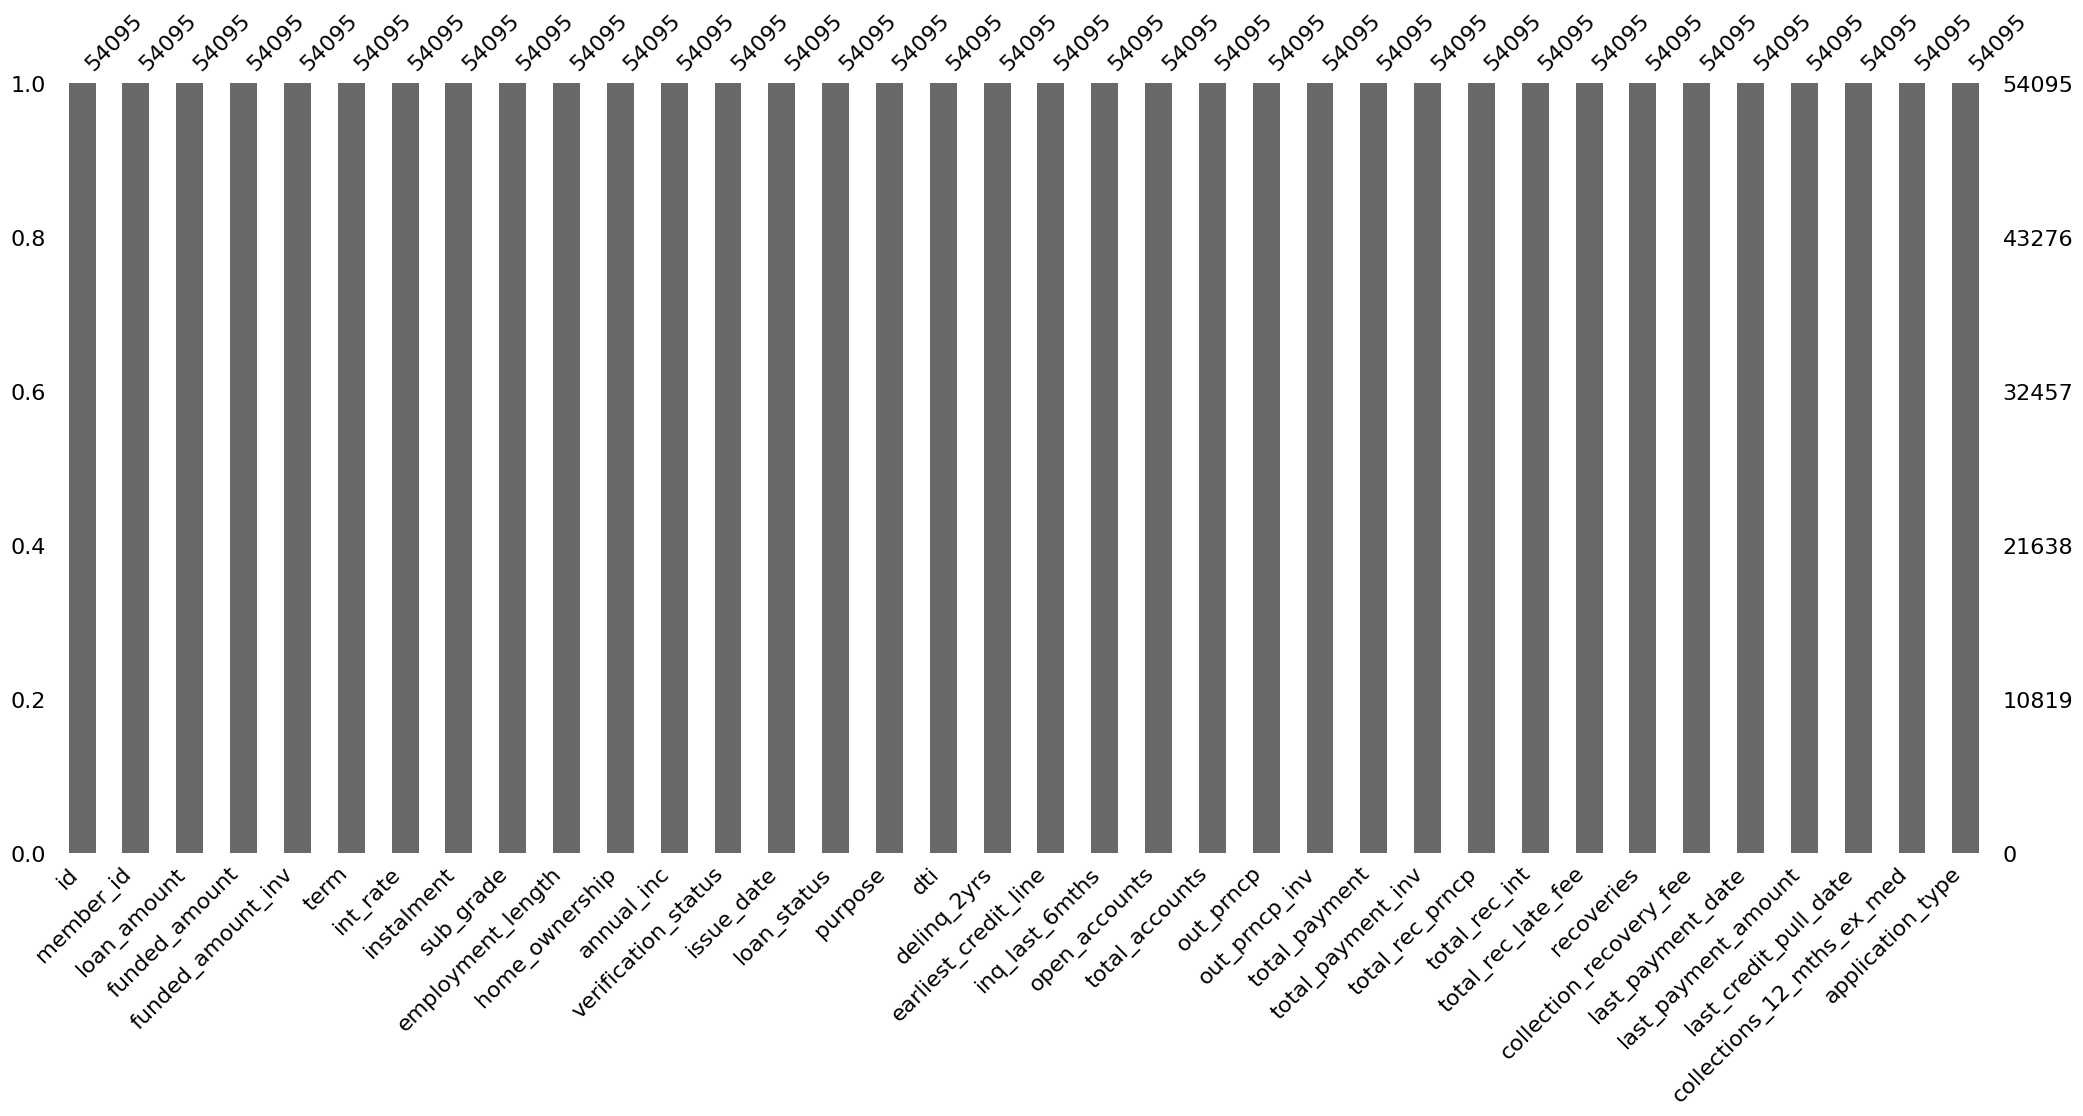

In [36]:
plotter.show_null_bar_chart(df)

### Skewed data

Lets first look at the skew value for each of the columns

In [37]:
# get a series showing the skew value for each column
skew_series = df_info.get_updated_skew_series(df, to_drop=['id', 'member_id'])
skew_series

annual_inc             8.740078
last_payment_amount    2.495972
out_prncp_inv          2.352797
out_prncp              2.352376
total_rec_int          2.203622
total_payment          1.269351
total_rec_prncp        1.261956
total_payment_inv      1.258693
open_accounts          1.059783
instalment             0.996249
funded_amount          0.869145
funded_amount_inv      0.814283
loan_amount            0.804361
total_accounts         0.780251
int_rate               0.455883
dti                    0.189027
dtype: float64

In order to decide a cut off point for considering a column as skewed, I will look into those which appear to be normally distributed. 

The table above shows the skewness of the numeric features, sorted with the highest first. 

The closer a skew value is to 0, the more normally distributed it is; those lower in the table have the least skew.

To determine a cuttoff point for skewness *I will look at the kde histplot for each of the **last 4** values in the table*, focusing on how the rise in the skew value affects the extend of the skew. 

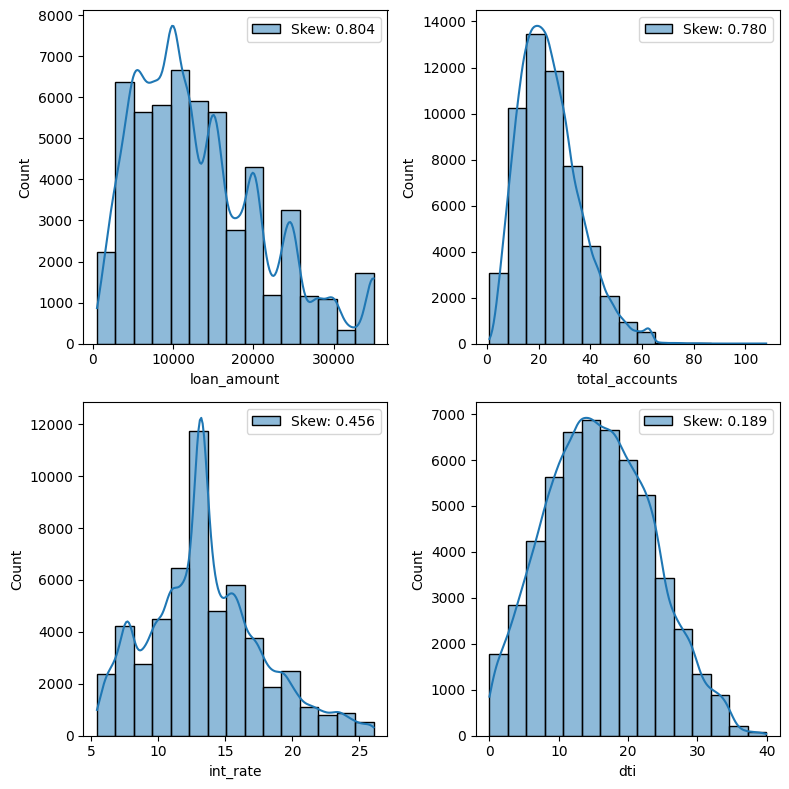

In [38]:
last_four_names = [str(col_name) for col_name in skew_series.tail(4).index]
plotter.plot_histogram_quad(df[last_four_names])

Looking at the plots I notice that the lowest skew values at which skewness becomes apparent is 0.78 for the total_accounts column.

The next lowest is int_rate with a value of 0.456, and that looks normally distributed enough. 

**As a result I am going to set my skew_threshold at 0.5.**

#### Transform skewed columns 

In [39]:
SKEW_THRESHOLD = 0.5

# Extract a series of the columns which are above the threshold.
skewed_columns = skew_series[skew_series > SKEW_THRESHOLD]

# Also store those below the threshold to track progress in reducing skew 
normally_distributed_columns = skew_series[skew_series <= SKEW_THRESHOLD]

Let's see the columns and their skews after applying the skew threshold.

In [40]:
print("Skewed columns:")
print(skewed_columns)
print("")
print("Normally distributed columns:")
print(normally_distributed_columns)

Skewed columns:
annual_inc             8.740078
last_payment_amount    2.495972
out_prncp_inv          2.352797
out_prncp              2.352376
total_rec_int          2.203622
total_payment          1.269351
total_rec_prncp        1.261956
total_payment_inv      1.258693
open_accounts          1.059783
instalment             0.996249
funded_amount          0.869145
funded_amount_inv      0.814283
loan_amount            0.804361
total_accounts         0.780251
dtype: float64

Normally distributed columns:
int_rate    0.455883
dti         0.189027
dtype: float64


First I am going to transform the column with the least skew:
`total_accounts` has a skew of `0.779`

Colum: total_accounts, with skew of 0.78.


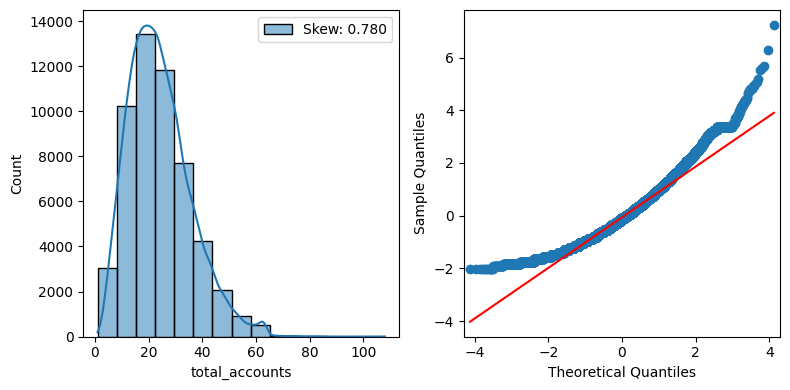

In [41]:
column = df["total_accounts"]
msg = plotter.plot_histogram_and_qq(column)
print(msg)

In [42]:
# Apply box cox transform 
transformed_column = df_transformer.box_cox_transform(column)
df = df_transformer.replace_column_after_box_cox(df, column, transformed_column)

Colum: total_accounts, with skew of -0.012.


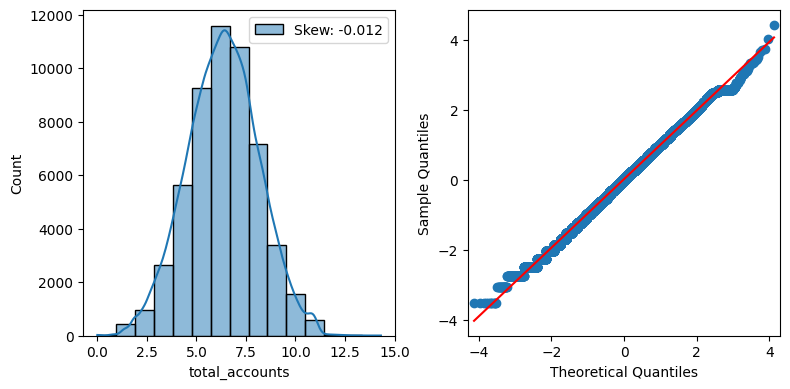

In [43]:
message = plotter.plot_histogram_and_qq(df["total_accounts"])
print(message)

In [44]:
# I initially applied a box-cox transform to all of the following columns:
# loan_amount, funded_amount, instalment, total_payment
# I then reversed that decision to retain more of the original data. This improved my ability to gain insights from the data in the coming steps. 

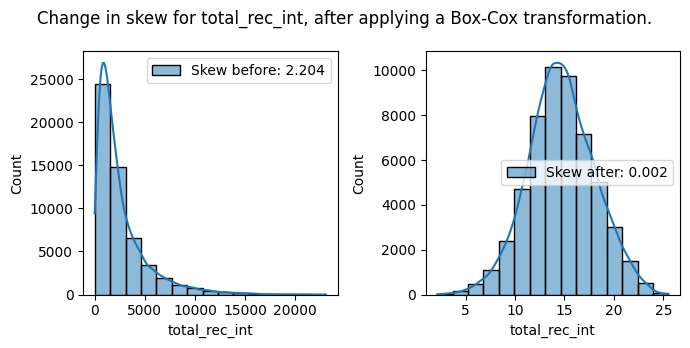

In [45]:
# Apply box cox transform 
column_before = df['total_rec_int']

transformed_column = df_transformer.box_cox_transform(df["total_rec_int"])
df = df_transformer.replace_column_after_box_cox(df, df["total_rec_int"], transformed_column)

plotter.plot_histogram_before_and_after_transform(column_before, transformed_column, transform_name="Box-Cox")

The columns `total_rec_prncp`, `total_payment_inv` and `funded_amount_inv` contain values equal to 0 and so require a Yeo-Johnson transform instead of a Box-Cox transform. 

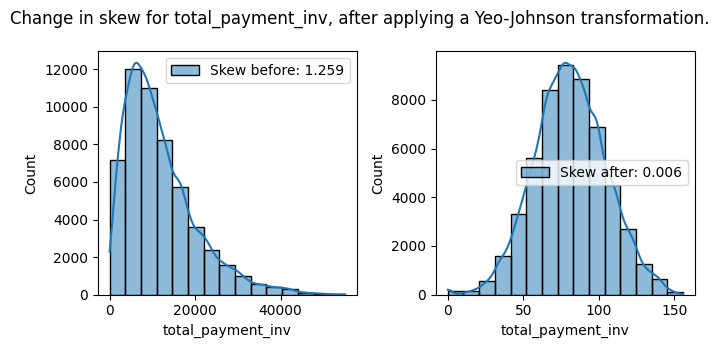

In [46]:
# Apply a Yeo-Johnson transform, and visualise the skewness before and after 
column_before = df['total_payment_inv']
column_after = df["total_payment_inv"] = df_transformer.yeo_johnson_transform(df['total_payment_inv'])

plotter.plot_histogram_before_and_after_transform(column_before, column_after, transform_name="Yeo-Johnson")

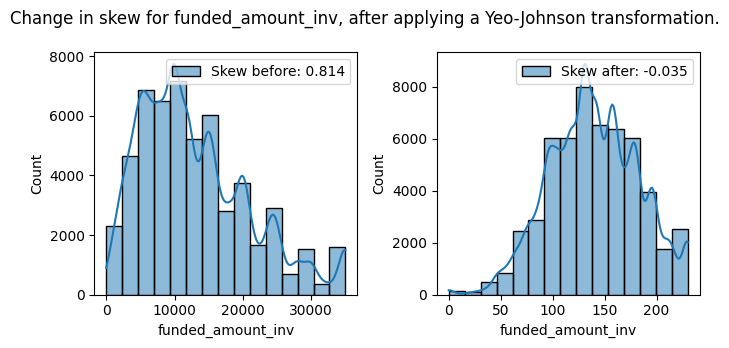

In [47]:
# Apply a Yeo-Johnson transform, and visualise the skewness before and after 
column_before = df['funded_amount_inv']
column_after = df["funded_amount_inv"] = df_transformer.yeo_johnson_transform(df['funded_amount_inv'])

plotter.plot_histogram_before_and_after_transform(column_before, column_after, transform_name="Yeo-Johnson")

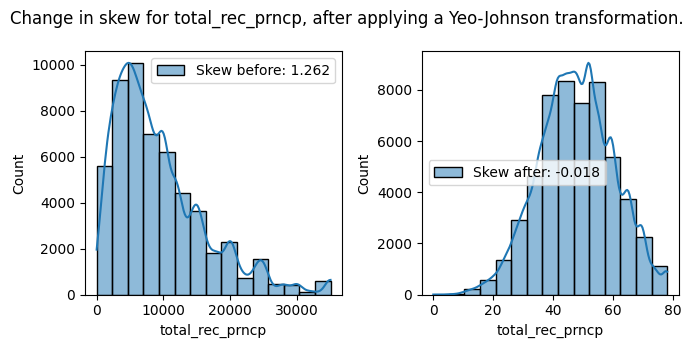

In [48]:
# Apply a Yeo-Johnson transform, and visualise the skewness before and after 
column_before = df['total_rec_prncp']
column_after = df["total_rec_prncp"] = df_transformer.yeo_johnson_transform(df['total_rec_prncp'])

plotter.plot_histogram_before_and_after_transform(column_before, column_after, transform_name="Yeo-Johnson")

In [49]:
# get a series showing the skew value for each column
skewed_columns = df_info.get_updated_skew_series(df, to_drop=['id', 'member_id'], threshold=SKEW_THRESHOLD)
normally_distributed_columns = df_info.get_normally_distributed_series(df, to_drop=['id', 'member_id'], threshold=SKEW_THRESHOLD)

print("Skewed columns:")
print(skewed_columns)
print("")
print("Normally distributed columns:")
print(normally_distributed_columns)

Skewed columns:
annual_inc             8.740078
last_payment_amount    2.495972
out_prncp_inv          2.352797
out_prncp              2.352376
total_payment          1.269351
open_accounts          1.059783
instalment             0.996249
funded_amount          0.869145
loan_amount            0.804361
dtype: float64

Normally distributed columns:
int_rate             0.455883
dti                  0.189027
total_payment_inv    0.005941
total_rec_int        0.002199
total_accounts      -0.012415
total_rec_prncp     -0.017778
funded_amount_inv   -0.035143
dtype: float64


### Dropping overly-correlated columns

Print the correlation heatmap for the numeric columns of the data frame 

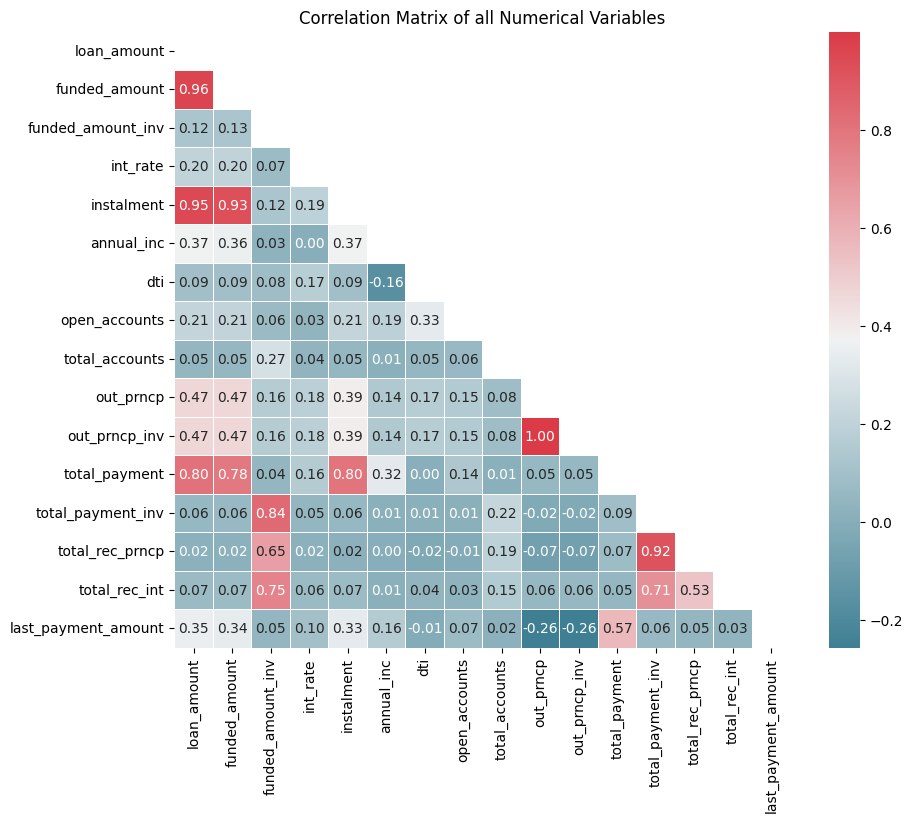

,loan_amount,funded_amount,funded_amount_inv,int_rate,instalment,annual_inc,dti,open_accounts,total_accounts,out_prncp,out_prncp_inv,total_payment,total_payment_inv,total_rec_prncp,total_rec_int,last_payment_amount
loan_amount,1.000000,0.964835,0.121453,0.203249,0.947038,0.369270,0.093086,0.212805,0.045581,0.468055,0.467986,0.804087,0.055763,0.016022,0.067141,0.347588
funded_amount,0.964835,1.000000,0.125490,0.200152,0.926722,0.355508,0.094593,0.208197,0.047805,0.467289,0.467252,0.779948,0.057795,0.016751,0.069044,0.336192
funded_amount_inv,0.121453,0.125490,1.000000,0.068629,0.121371,0.028505,0.079075,0.063778,0.274158,0.163080,0.163076,0.043577,0.837008,0.654939,0.748182,0.047058
int_rate,0.203249,0.200152,0.068629,1.000000,0.190928,0.003461,0.171858,0.034547,0.035906,0.183351,0.183450,0.156992,0.045414,0.015002,0.063568,0.100424
instalment,0.947038,0.926722,0.121371,0.190928,1.000000,0.371099,0.092056,0.213127,0.047775,0.390230,0.390212,0.798876,0.056378,0.020030,0.070038,0.331239
annual_inc,0.369270,0.355508,0.028505,0.003461,0.371099,1.000000,-0.162907,0.186615,0.012673,0.143443,0.143410,0.324591,0.010256,0.002454,0.011677,0.155700
dti,0.093086,0.094593,0.079075,0.171858,0.092056,-0.162907,1.000000,0.327809,0.051749,0.170142,0.170145,0.004990,0.011001,-0.024918,0.036243,-0.012753
open_accounts,0.212805,0.208197,0.063778,0.034547,0.213127,0.186615,0.327809,1.000000,0.061472,0.153718,0.153702,0.138433,0.009807,-0.010364,0.030642,0.072135
total_accounts,0.045581,0.047805,0.274158,0.035906,0.047775,0.012673,0.051749,0.061472,1.000000,0.077573,0.077554,0.010182,0.218397,0.194392,0.153242,0.019789
out_prncp,0.468055,0.467289,0.163080,0.183351,0.390230,0.143443,0.170142,0.153718,0.077573,1.000000,0.999995,0.054933,-0.019249,-0.074622,0.055841,-0.256635


In [50]:
numeric_df = df_info.get_numeric_columns_from_df(df).drop(['id', 'member_id'], axis=1)
matrix = plotter.correlation_matrix(numeric_df)

I am going to remove all columns with a correlation greater than .90. In each case I will decide which of the two related columns is best to drop.

In [51]:
df = df_transformer.drop_column(df, df['instalment'])
df = df_transformer.drop_column(df, df['total_payment_inv'])
df = df_transformer.drop_column(df, df['funded_amount'])
df = df_transformer.drop_column(df, df['out_prncp_inv'])

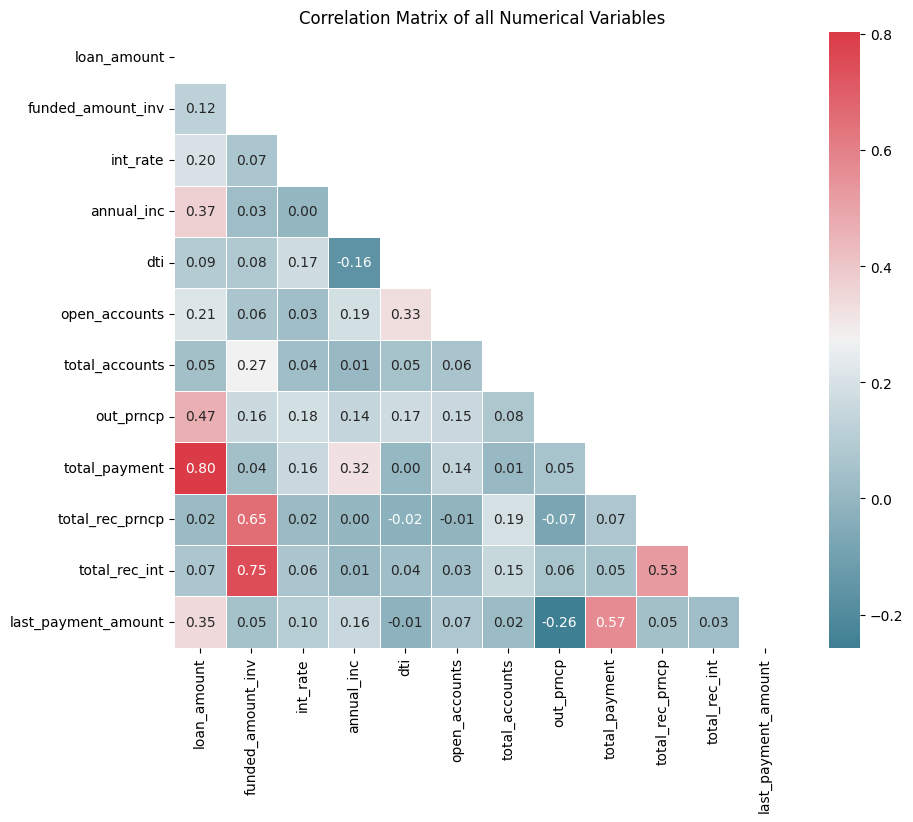

,loan_amount,funded_amount_inv,int_rate,annual_inc,dti,open_accounts,total_accounts,out_prncp,total_payment,total_rec_prncp,total_rec_int,last_payment_amount
loan_amount,1.000000,0.121453,0.203249,0.369270,0.093086,0.212805,0.045581,0.468055,0.804087,0.016022,0.067141,0.347588
funded_amount_inv,0.121453,1.000000,0.068629,0.028505,0.079075,0.063778,0.274158,0.163080,0.043577,0.654939,0.748182,0.047058
int_rate,0.203249,0.068629,1.000000,0.003461,0.171858,0.034547,0.035906,0.183351,0.156992,0.015002,0.063568,0.100424
annual_inc,0.369270,0.028505,0.003461,1.000000,-0.162907,0.186615,0.012673,0.143443,0.324591,0.002454,0.011677,0.155700
dti,0.093086,0.079075,0.171858,-0.162907,1.000000,0.327809,0.051749,0.170142,0.004990,-0.024918,0.036243,-0.012753
open_accounts,0.212805,0.063778,0.034547,0.186615,0.327809,1.000000,0.061472,0.153718,0.138433,-0.010364,0.030642,0.072135
total_accounts,0.045581,0.274158,0.035906,0.012673,0.051749,0.061472,1.000000,0.077573,0.010182,0.194392,0.153242,0.019789
out_prncp,0.468055,0.163080,0.183351,0.143443,0.170142,0.153718,0.077573,1.000000,0.054933,-0.074622,0.055841,-0.256635
total_payment,0.804087,0.043577,0.156992,0.324591,0.004990,0.138433,0.010182,0.054933,1.000000,0.073755,0.050512,0.569409
total_rec_prncp,0.016022,0.654939,0.015002,0.002454,-0.024918,-0.010364,0.194392,-0.074622,0.073755,1.000000,0.529048,0.045650


In [52]:
numeric_df = df_info.get_numeric_columns_from_df(df).drop(['id', 'member_id'], axis=1)
matrix = plotter.correlation_matrix(numeric_df)

In [53]:
df.head()

,id,member_id,loan_amount,funded_amount_inv,term,int_rate,sub_grade,employment_length,home_ownership,annual_inc,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,last_credit_pull_date,collections_12_mths_ex_med,application_type
0,38676116,41461848,8000,118.658822,36 months,7.49,A4,5 years,MORTGAGE,46000.0,...,32.738030,10.850478,0,0,0,2022-01-01,248.82,2022-01-01,0.0,INDIVIDUAL
1,38656203,41440010,13200,148.683017,36 months,6.99,A3,9 years,RENT,50000.0,...,38.800926,12.088905,0,0,0,2022-01-01,407.52,2022-01-01,0.0,INDIVIDUAL
2,38656154,41439961,16000,162.107146,36 months,7.49,A4,8 years,MORTGAGE,73913.0,...,60.704537,12.224619,0,0,0,2021-10-01,12850.16,2021-10-01,0.0,INDIVIDUAL
3,38656128,41439934,15000,157.475417,36 months,14.31,C4,1 year,RENT,42000.0,...,59.446593,12.646329,0,0,0,2021-06-01,13899.67,2021-06-01,0.0,INDIVIDUAL
4,38656121,41439927,15000,157.475417,36 months,6.03,A1,10+ years,MORTGAGE,145000.0,...,40.622644,12.024028,0,0,0,2022-01-01,456.54,2022-01-01,0.0,INDIVIDUAL


### Data Analysis 

Query the data to check the current state of payments. 

Summarise what percentage of the loans are recovered against the investor funding and the total amount funded.

Extend this query to project what percentage of the total would be recovered up to 6 months' in the future and visualise the data.

In [54]:
# Lets have a review of what columns are available to us
df.columns

Index(['id', 'member_id', 'loan_amount', 'funded_amount_inv', 'term',
       'int_rate', 'sub_grade', 'employment_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_date', 'loan_status',
       'purpose', 'dti', 'delinq_2yrs', 'earliest_credit_line',
       'inq_last_6mths', 'open_accounts', 'total_accounts', 'out_prncp',
       'total_payment', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_payment_date', 'last_payment_amount', 'last_credit_pull_date',
       'collections_12_mths_ex_med', 'application_type'],
      dtype='object')

In [55]:
# Extract some potentially useful features relating to the state of payments 
payment_related_columns = df[['loan_amount', 'funded_amount_inv', 'total_rec_prncp', 'total_payment', 'out_prncp', 'loan_status', 'int_rate', 'annual_inc', 'dti']]
payment_related_columns.head()

,loan_amount,funded_amount_inv,total_rec_prncp,total_payment,out_prncp,loan_status,int_rate,annual_inc,dti
0,8000,118.658822,32.738030,2982.51,5529.70,Current,7.49,46000.0,19.54
1,13200,148.683017,38.800926,4885.11,9102.83,Current,6.99,50000.0,24.20
2,16000,162.107146,60.704537,16824.54,0.00,Fully Paid,7.49,73913.0,16.92
3,15000,157.475417,59.446593,15947.47,0.00,Fully Paid,14.31,42000.0,35.52
4,15000,157.475417,40.622644,5473.46,10297.47,Current,6.03,145000.0,3.33


In [56]:
# Summarise what percentage of the loans are recovered against the investor funding 
investor_funding = df['funded_amount_inv']
# amount_recovered = df['']
 
# Summarise what percentage of the loans are recovered against the total amount funded.